In [53]:
import sys
sys.path.append('../notebooks')

import pandas as pd
import numpy as np
import tensorflow as tf

import importlib
import simpleautoencoder2
importlib.reload(simpleautoencoder2)

from simpleautoencoder2 import Autoencoder, loss, train, Encoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('./fp_injectables_data.csv')

y = df['outcome'] * 1
a = df['treatment'] * 1
X = df[df.columns[:-2]]
X = X.apply(lambda x: x.fillna(x.median()),axis='rows')


In [59]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

encoding = pd.read_csv('encoding-Copy1.csv')

# Select and Encode ordinal features
v = encoding[encoding['encoding'] == 'O']['var_name'].values
enc = OrdinalEncoder()
ord_data = enc.fit_transform(X[v])
ord_features = v

# Select and Encode nominal features
v = encoding[encoding['encoding'] == 'L']['var_name'].values
j = X[v].astype(int)
enc = OneHotEncoder(categories='auto')
nom_data = enc.fit_transform(j)
nom_data.dtype = int
nom_features = enc.get_feature_names(v)

# Select the discrete features
v = encoding[encoding['encoding'] == 'N']['var_name'].values
dis_data = X[v].values
dis_features = v


# Combine all the features
X_arr = np.concatenate((ord_data, nom_data.toarray(), dis_data), axis=1)
features_names = np.concatenate((ord_features, nom_features, dis_features))

print(X_arr.shape)
X_df = pd.DataFrame(X_arr, columns=features_names)

(5649, 317)


In [68]:
enc = OneHotEncoder(categories='auto')
label_data = enc.fit_transform(a.values.reshape(-1, 1))
label_data = label_data.toarray()

In [4]:
train_data = X_df.values

In [19]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 1e-2
batch_size = 128
epochs = 50
dim = 317

autoencoder = Autoencoder(intermediate_dim=64, original_dim=dim)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

data = StandardScaler().fit_transform(X_df.values)
training_features, test_features = train_test_split(data)
training_features = training_features.astype('float32')
training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(epochs):
            for step, batch_features in enumerate(training_dataset):
                train(loss, autoencoder, opt, batch_features)
                loss_values = loss(autoencoder, batch_features)

                original = batch_features
                reconstructed = autoencoder(tf.constant(batch_features))
                
            tf.summary.scalar('loss', loss_values, step=step)
            tf.summary.histogram('original', original, step=step)
            tf.summary.histogram('reconstructed', reconstructed,  step=step)


test_loss = loss(autoencoder, test_features.astype('float32'))                
print(test_loss.numpy())         

0.7110724


In [88]:
class fc(tf.keras.Model):
    def __init__(self, intermediate_dim, num_classes):
        super(fc, self).__init__()
        self.encoder = Encoder(intermediate_dim=intermediate_dim)
        self.output_layer = tf.keras.layers.Dense(units=num_classes, activation=tf.nn.softmax)
    
    def call(self, input_features):
        encoded = self.encoder(input_features)
        return self.output_layer(encoded)

def loss(model, input_features, label):

    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(label, model(input_features)))
    return loss

def train(loss, model, opt, input_features, label):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, input_features, label), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [98]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 1e-2
batch_size = 128
epochs = 50
dim = 317

autoencoder = fc(intermediate_dim=64, num_classes=2)
opt = tf.optimizers.Adam(learning_rate=learning_rate)

data = StandardScaler().fit_transform(X_df.values)
training_features, test_features, train_label, test_label = train_test_split(data, label_data)
training_features = training_features.astype('float32')

training_dataset = tf.data.Dataset.from_tensor_slices((training_features, train_label))
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

writer = tf.summary.create_file_writer('tmp')

with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(epochs):
            for step, (batch_features, batch_labels) in enumerate(training_dataset):
                train(loss, autoencoder, opt, batch_features, batch_labels)
                loss_values = loss(autoencoder, batch_features, batch_labels)
            tf.summary.scalar('fcc-loss', loss_values, step=epoch)

test_loss = loss(autoencoder, test_features.astype('float32'), test_label)                
print(test_loss.numpy())          

1.9480753


In [108]:
predict_proba = autoencoder(data.astype('float32')).numpy()
overlap = 1.0*(np.min(predict_proba,1) >= 0.1)

In [115]:
from sklearn.metrics import roc_auc_score
roc_auc_score(label_data, predict_proba)

0.9493330461833616

In [32]:
embeddings = autoencoder.encoder(data.astype('float32')).numpy()

In [26]:
from scipy.stats import wasserstein_distance

In [42]:
idist = []
for i in range(len(embeddings)):
    jdist = []
    for j in range(len(embeddings)):
        d = wasserstein_distance(embeddings[i], embeddings[j])
        jdist.append(d)
    idist.append(jdist)

In [6]:
# dist_arr = np.array(idist)
dist_arr = np.load('fp_autoencoder_dist_arr.npy')
treated_untreated = dist_arr[a[a==1].index][:, a[a==0].index]

(array([1018., 1576.,  802.,  435.,  239.,  106.,   44.,   14.,    4.,
           3.]),
 array([0.09189656, 0.24790996, 0.40392337, 0.55993678, 0.71595018,
        0.87196359, 1.027977  , 1.1839904 , 1.34000381, 1.49601722,
        1.65203062]),
 <a list of 10 Patch objects>)

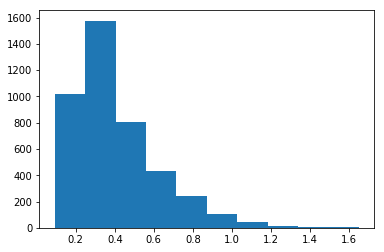

In [15]:
import matplotlib.pyplot as plt
plt.hist(treated_untreated[20])

(array([159., 382., 309., 225., 173.,  89.,  32.,  25.,   9.,   5.]),
 array([0.12015467, 0.26589773, 0.41164079, 0.55738385, 0.7031269 ,
        0.84886996, 0.99461302, 1.14035608, 1.28609914, 1.43184219,
        1.57758525]),
 <a list of 10 Patch objects>)

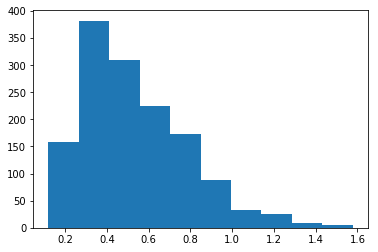

In [29]:
plt.hist(treated_untreated[:, 20])

In [65]:
np.save('fp_autoencoder_dist_arr', dist_arr)

In [32]:
l_data = pd.read_stata('http://www.nber.org/~rdehejia/data/nsw.dta')

In [41]:
columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end

treated = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_treated.txt", 
                      delim_whitespace=True, header=None, names=columns)
control = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_control.txt",
                      delim_whitespace=True, header=None, names=columns)
lalonde = pd.concat([treated, control], ignore_index=True)
# lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle

print(lalonde.shape)
lalonde.head()

(445, 10)


,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


In [44]:
non_exp = pd.read_csv('http://users.nber.org/~rdehejia/data/cps3_controls.txt', 
                      delim_whitespace=True, header=None, names=columns)

In [50]:
non_exp.head()

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
0,0.0,30.0,12.0,0.0,0.0,1.0,0.0,20166.73,18347.23,25564.67
1,0.0,26.0,12.0,0.0,0.0,1.0,0.0,25862.32,17806.55,25564.67
2,0.0,25.0,16.0,0.0,0.0,1.0,0.0,25862.32,15316.21,25564.67
3,0.0,42.0,11.0,0.0,0.0,1.0,1.0,21787.05,14265.29,15491.01
4,0.0,25.0,9.0,1.0,0.0,1.0,1.0,14829.69,13776.53,0.00
